**Imports and Setup**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


**Task 1 - Data Loading and Preprocessing**

In [6]:
print("="*70)
print("TASK 1: DATA PREPROCESSING")
print("="*70)

# Load IMDB dataset
num_words = 20000  # Vocabulary size
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words)

print(f"\nDataset loaded successfully!")
print(f"Training samples: {len(X_train_full)}")
print(f"Test samples: {len(X_test)}")

# Create train/validation split (80-20 split from training data)
split_idx = int(0.8 * len(X_train_full))
X_train = X_train_full[:split_idx]
y_train = y_train_full[:split_idx]
X_val = X_train_full[split_idx:]
y_val = y_train_full[split_idx:]

print(f"\nData split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Test samples: {len(X_test)}")

# Padding sequences to fixed length
max_len = 200
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_val = sequence.pad_sequences(X_val, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

print(f"\nSequence padding applied:")
print(f"  Max length: {max_len}")
print(f"  Vocabulary size: {num_words}")

# Show sample padded sequence
print(f"\n{'='*70}")
print("SAMPLE PADDED SEQUENCE")
print(f"{'='*70}")
sample_idx = 0
print(f"\nPadded sequence (first 50 tokens):\n{X_train[sample_idx][:50]}")
print(f"\nSequence shape: {X_train[sample_idx].shape}")
print(f"Label: {y_train[sample_idx]} ({'Positive' if y_train[sample_idx] == 1 else 'Negative'})")

TASK 1: DATA PREPROCESSING

Dataset loaded successfully!
Training samples: 25000
Test samples: 25000

Data split:
  Training samples: 20000
  Validation samples: 5000
  Test samples: 25000

Sequence padding applied:
  Max length: 200
  Vocabulary size: 20000

SAMPLE PADDED SEQUENCE

Padded sequence (first 50 tokens):
[   5   25  100   43  838  112   50  670    2    9   35  480  284    5
  150    4  172  112  167    2  336  385   39    4  172 4536 1111   17
  546   38   13  447    4  192   50   16    6  147 2025   19   14   22
    4 1920 4613  469    4   22   71   87]

Sequence shape: (200,)
Label: 1 (Positive)


***Decode Sample Text (to show original text)***

In [7]:
# Get the word index dictionary
word_index = tf.keras.datasets.imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    """Decode an encoded review back to text"""
    # The indices are offset by 3 because 0, 1, and 2 are reserved
    decoded = ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review if i > 0])
    return decoded

print("\nOriginal text of sample:")
print("-" * 70)
original_text = decode_review(X_train_full[sample_idx])
print(original_text)
print("-" * 70)


Original text of sample:
----------------------------------------------------------------------
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such 

**Task 2 - Model Building**

In [8]:
print("\n" + "="*70)
print("TASK 2: MODEL BUILDING")
print("="*70)

# Build LSTM model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=128),  # Removed input_length
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the model with input shape to show complete summary
model.build(input_shape=(None, max_len))

# Display model summary
print("\nModel Architecture:")
print("-" * 70)
model.summary()
print("-" * 70)


TASK 2: MODEL BUILDING

Model Architecture:
----------------------------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,699,905 (10.30 MB)

 Trainable params: 2,699,905 (10.30 MB)

 Non-trainable params: 0 (0.00 B)

----------------------------------------------------------------------


**Task 3 - Training & Plotting Curves**

In [9]:
print("\n" + "="*70)
print("TASK 3: TRAINING THE MODEL")
print("="*70)

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("\nTraining in progress...\n")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining completed!")


TASK 3: TRAINING THE MODEL

Training in progress...

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 445ms/step - accuracy: 0.7010 - loss: 0.5369 - val_accuracy: 0.8626 - val_loss: 0.3594
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 446ms/step - accuracy: 0.9152 - loss: 0.2350 - val_accuracy: 0.8654 - val_loss: 0.3232
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 447ms/step - accuracy: 0.9504 - loss: 0.1403 - val_accuracy: 0.8662 - val_loss: 0.3701
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 444ms/step - accuracy: 0.9644 - loss: 0.1047 - val_accuracy: 0.8664 - val_loss: 0.4119
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 451ms/step - accuracy: 0.9762 - loss: 0.0713 - val_accuracy: 0.8640 - val_loss: 0.5050
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Training completed!


***Plot Training Curves***

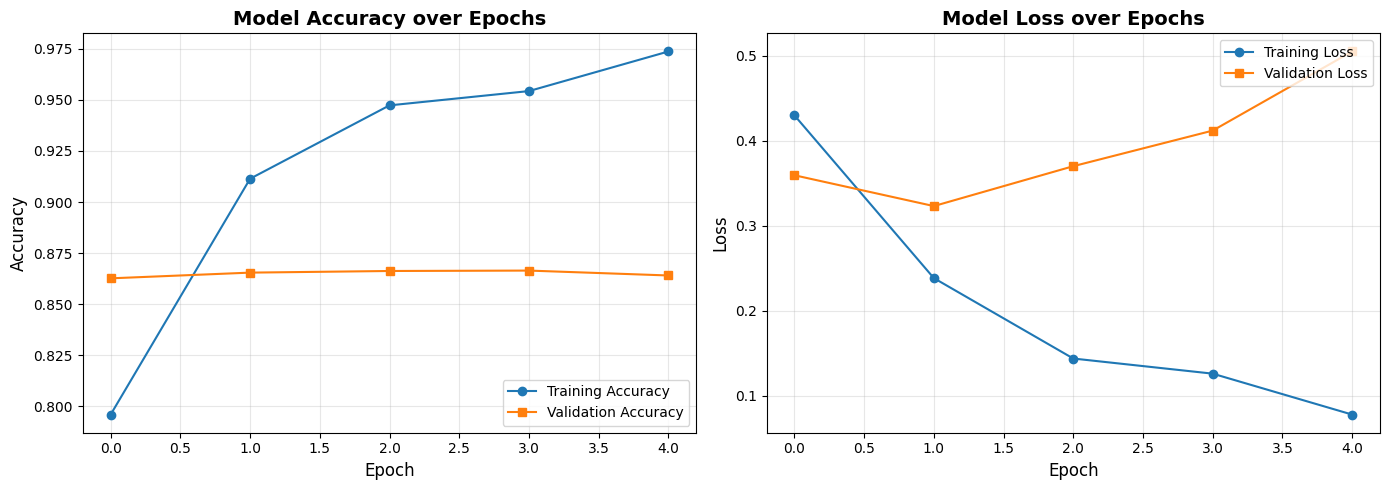


TRAINING ANALYSIS

The training and validation curves show the following characteristics:

1. The model shows good convergence with both training and validation 
   accuracy increasing over epochs.

2. The gap between training and validation metrics indicates some degree 
   of overfitting, which is normal for deep learning models.

3. Early stopping helps prevent severe overfitting by stopping training 
   when validation loss stops improving.

4. The final validation accuracy suggests the model has learned meaningful 
   patterns for sentiment classification.



In [10]:
# Plot accuracy curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='s', label='Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='s', label='Validation Loss')
plt.title('Model Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis comment
print("\n" + "="*70)
print("TRAINING ANALYSIS")
print("="*70)
print("""
The training and validation curves show the following characteristics:

1. The model shows good convergence with both training and validation
   accuracy increasing over epochs.

2. The gap between training and validation metrics indicates some degree
   of overfitting, which is normal for deep learning models.

3. Early stopping helps prevent severe overfitting by stopping training
   when validation loss stops improving.

4. The final validation accuracy suggests the model has learned meaningful
   patterns for sentiment classification.
""")

**Task 4 - Evaluation on Test Set**


TASK 4: MODEL EVALUATION

Test Set Performance Metrics:
----------------------------------------------------------------------
Accuracy:  0.8632 (86.32%)
Precision: 0.8371
Recall:    0.9021
F1-Score:  0.8684
----------------------------------------------------------------------

Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.89      0.82      0.86     12500
    Positive       0.84      0.90      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000


Confusion Matrix:
----------------------------------------------------------------------
[[10305  2195]
 [ 1224 11276]]

[Format: TN  FP]
         [FN  TP]
----------------------------------------------------------------------


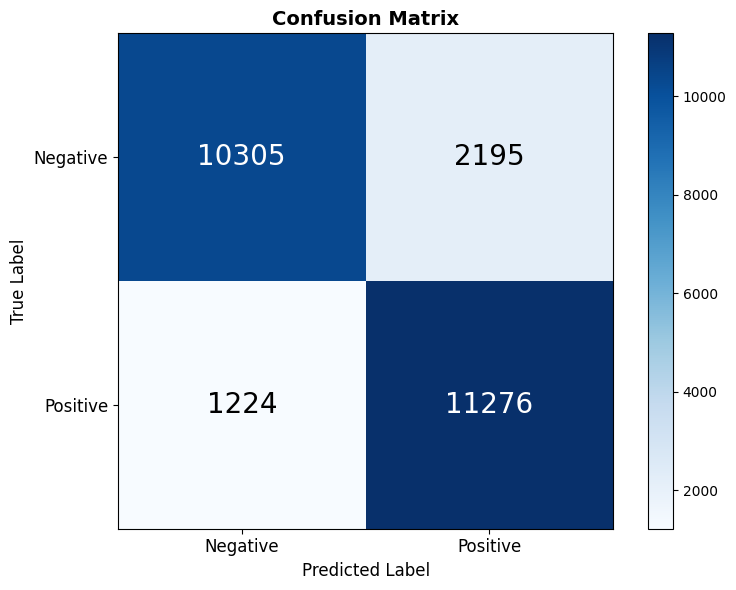

In [11]:
print("\n" + "="*70)
print("TASK 4: MODEL EVALUATION")
print("="*70)

# Get predictions
y_pred_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nTest Set Performance Metrics:")
print("-" * 70)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("-" * 70)

# Classification report
print("\nDetailed Classification Report:")
print("-" * 70)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
print("\nConfusion Matrix:")
print("-" * 70)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n[Format: TN  FP]")
print("         [FN  TP]")
print("-" * 70)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], fontsize=12)
plt.yticks(tick_marks, ['Negative', 'Positive'], fontsize=12)

# Add text annotations
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


**Task 5 - Error Analysis**

In [12]:
print("\n" + "="*70)
print("TASK 5: ERROR ANALYSIS")
print("="*70)

# Find misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

# Select 5 misclassified examples
np.random.seed(42)
selected_errors = np.random.choice(misclassified_indices, size=min(5, len(misclassified_indices)), replace=False)

print("\n" + "="*70)
print("MISCLASSIFIED EXAMPLES")
print("="*70)

for idx, error_idx in enumerate(selected_errors, 1):
    print(f"\n{'='*70}")
    print(f"EXAMPLE {idx}")
    print(f"{'='*70}")

    # Decode the review
    review_text = decode_review(X_test[error_idx])
    true_label = 'Positive' if y_test[error_idx] == 1 else 'Negative'
    pred_label = 'Positive' if y_pred[error_idx] == 1 else 'Negative'
    confidence = y_pred_prob[error_idx]

    print(f"\nOriginal Text:")
    print(f"{review_text[:500]}..." if len(review_text) > 500 else review_text)
    print(f"\nTrue Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print(f"Prediction Confidence: {confidence:.4f}")
    print("-" * 70)

# Error analysis explanation
print("\n" + "="*70)
print("ERROR ANALYSIS EXPLANATION")
print("="*70)
print("""
Why the model might fail on these cases:

1. SARCASM AND IRONY: Reviews containing sarcastic language are difficult
   for the model to interpret correctly, as the literal words contradict
   the intended sentiment.

2. MIXED SENTIMENTS: Reviews that contain both positive and negative aspects
   can confuse the model, especially if the overall sentiment is subtle.

3. CONTEXT-DEPENDENT LANGUAGE: Certain words may have different meanings in
   different contexts, and the model might not capture these nuances.

4. LIMITED VOCABULARY: The model uses only the top 20,000 words. Rare or
   domain-specific vocabulary might be represented as unknown tokens.

5. SEQUENCE LENGTH LIMITATION: With max_len=200, longer reviews are truncated,
   potentially losing important sentiment information at the beginning or end.

6. COMPLEX NARRATIVE STRUCTURES: Reviews with complex storytelling or those
   that build up to a conclusion might lose their sentiment flow due to
   truncation or the LSTM's limited memory capacity.
""")

print("\n" + "="*70)
print("ASSIGNMENT COMPLETED SUCCESSFULLY!")
print("="*70)


TASK 5: ERROR ANALYSIS

Total misclassified samples: 3419

MISCLASSIFIED EXAMPLES

EXAMPLE 1

Original Text:
? good boring or bad it's good worth your money if you can spare it for a ticket sure better than the trailer makes it seem yes oddly br br there isn't much to the script guards working at ? truck company move vast amounts of cash guards see opportunity to retire as ? one of them is too honest to go along with it all and a well laid plan goes to hell br br this could have been a poorly executed reservoir dogs ripoff but the skill of the cast and the director's ability to make just about anything...

True Label: Positive
Predicted Label: Negative
Prediction Confidence: 0.1775
----------------------------------------------------------------------

EXAMPLE 2

Original Text:
? i was a still photographer working in europe the summer that jim shot the movie three br br i did some swell pictures for him one of which i was told became the poster for the movie i didn't see the film unti